<a href="https://colab.research.google.com/github/Nusserle/LieDetection/blob/master/LieDetectionEEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy import signal

import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

plt.rcParams['figure.figsize'] = (18, 6)

Using TensorFlow backend.


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [17]:
%cd drive/My Drive/Shared/BagOfLies/
df = pd.read_csv("Annotations.csv")
df.head()

/content/drive/My Drive/Shared/BagOfLies


In [0]:
df_eeg = df[['eeg', 'truth']].dropna().reset_index()

In [168]:
df_curr = pd.read_csv(df_eeg.iloc[0,:][1]).iloc[:,1:-1]
df_curr

,F3 Value,F3 Quality,FC5 Value,5C5 Quality,F7 Value,F7 Quality,T7 Value,T7 Quality,P7 Value,P7 Quality,O1 Value,O1 Quality,O2 Value,O2 Quality,P8 Value,P8 Quality,T8 Value,T8 Quality,F8 Value,F8 Quality,AF4 Value,AF4 Quality,FC6 Value,FC6 Quality,F4 Value,F4 Quality,X Value,Y Value
0,-107,0,-118,0,-122,0,-131,0,-113,0,-121,0,-109,0,-90,0,-127,0,-110,0,-116,0,-93,0,-82,0,22,24
1,-109,0,-122,0,-115,0,-97,0,-131,0,-124,0,-86,0,-82,0,-97,0,-121,0,-100,0,-83,0,-75,0,22,24
2,-119,0,-125,0,-123,0,-99,0,-112,0,-123,0,-94,0,-80,0,-98,0,-118,0,-96,0,-114,0,-79,0,22,23
3,-131,0,-125,0,-120,0,-98,0,-106,0,-124,0,-120,0,-99,0,-99,0,-127,0,-118,0,-106,0,-86,0,22,23
4,-131,0,-117,0,-121,0,-98,1344,-129,0,-124,0,-111,0,-104,0,-94,0,-124,0,-114,0,-46,0,-82,0,22,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1576,-114,4800,-121,8,-122,16,-124,1704,-113,8016,-124,0,-135,5392,-150,312,-121,16,-115,5896,-131,5848,-32,1448,-103,1888,22,24
1577,-110,4800,-123,8,-123,16,-122,1704,-81,8016,-123,0,-95,5392,-79,312,-124,16,-88,5896,-113,5848,-25,1448,-91,1888,22,24
1578,-123,4800,-127,8,-123,16,-120,1704,-96,8016,-122,0,-94,5392,-73,312,-118,16,-96,5896,-122,5848,-19,1448,-89,1888,22,24
1579,-127,4800,-123,8,-121,16,-125,1704,-129,8016,-126,0,-133,5392,-128,312,-126,16,-130,5896,-138,5848,-108,1448,-92,1888,21,24


In [0]:
# Filter EEG table only for values (except for X and Y Value)
# What is Quality? and X Value and Y Value
df_filtered = df_curr.loc[:, df_curr.columns.str.contains('Value')]
df_filtered = df_filtered.iloc[:,:-2]

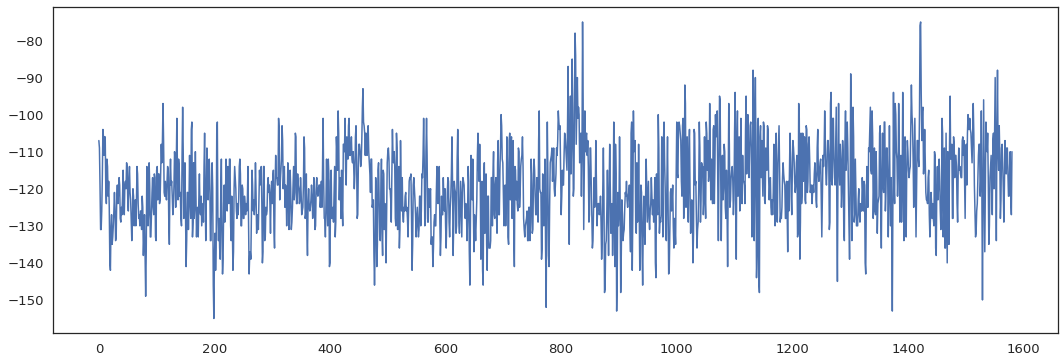

In [170]:
# EEG Signal from channel F3 with noise
f3_channel_eeg = df_filtered.iloc[:,:1]
plt.plot(f3_channel_eeg)

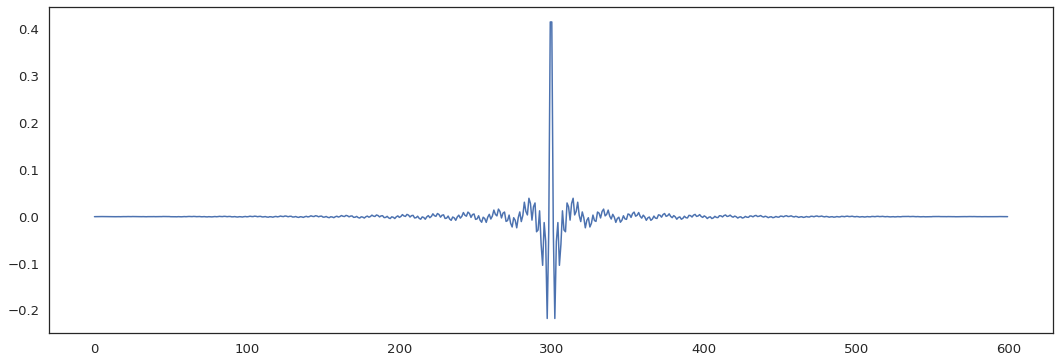

In [173]:
# Filter
filter = signal.firwin(600, [0.1, 0.6], pass_zero=False)
plt.plot(filter)
plt.show()

In [0]:
# Normalized values
data_norm_to_0_1 = [number/scipy.linalg.norm(f3_channel_eeg.squeeze()) for number in f3_channel_eeg.squeeze()]

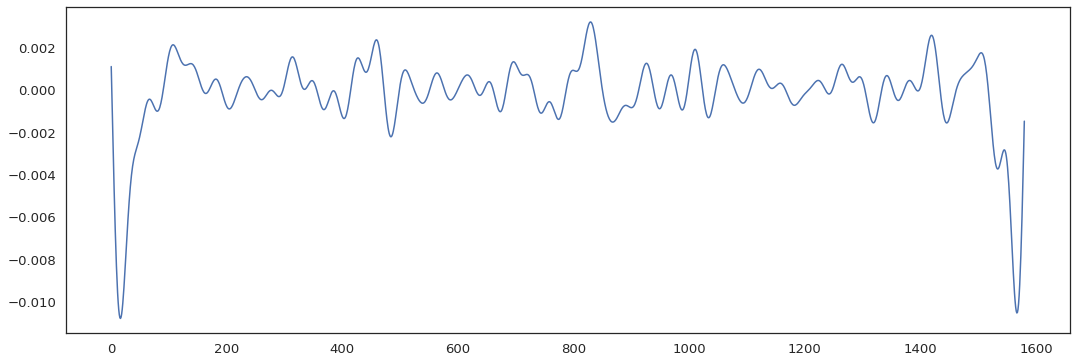

In [177]:
# Applied filter to normalized signal
filter = signal.firwin(400, [0.01, 0.06], pass_zero=False)
filtered_and_normalized = signal.convolve(data_norm_to_0_1, filter, mode="same")
plt.plot(filtered_and_normalized)

In [0]:
data = []
current_max_dimension = 0
for i, eeg in df_eeg.iterrows():
  df_curr = pd.read_csv(eeg[1]).iloc[:,1:-1]
  if df_curr.shape[0] > current_max_dimension:
    current_max_dimension = df_curr.shape[0]
print(current_max_dimension)

data = np.zeros((df_eeg.shape[0], current_max_dimension, 1))
label = []
for i, eeg in df_eeg.iterrows():
  df_cleared = df_curr.apply(lambda x: pd.to_numeric(x, errors = 'coerce')).dropna()
  x = df_cleared.values #returns a numpy array
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  for k, row in enumerate(x_scaled):
    for j, val in enumerate(row):
      if j > 0:
        pass
      else:
        data[i][k][j] = val
  label.append(eeg[2])
label = np.asarray(label)

In [41]:
print(data.shape)
print(label.shape)

(201, 4867, 1)
(201,)


In [0]:
X_train = data[:120]
y_train = label[:120]
X_val = data[120:150]
y_val = label[120:150]
X_test = data[150:]
y_test = label[150:]

In [0]:
model = models.Sequential()
model.add(layers.LSTM(4869, activation='relu' ,input_shape=(4867,1,)))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(X_train,
                    y_train,
                    epochs=5,
                    batch_size=30,
                    validation_data=(X_val, y_val), verbose=1)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 120 samples, validate on 30 samples
Epoch 1/5







In [0]:
model2 = models.Sequential()
#model2.add(layers.LSTM(57, activation='tanh' ,input_shape=(57,300,)))
model2.add(layers.Dense(57, activation='relu' ,input_shape=(57,300,)))
#model.add(layers.Conv1D(64, 5, activation='relu',input_shape=(57,300,)))
#model.add(layers.GlobalMaxPooling1D())
#model.add(layers.GRU(64, activation='tanh', input_shape=(57,300,)))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(38, activation='relu'))
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['acc'])